# Marker-Controlled Watershed Segmentation

In [1]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

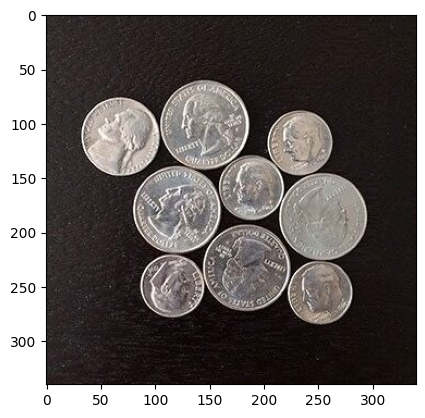

In [2]:
# read image
raw = Image.open("./input_image.jpg")
plt.imshow(raw)

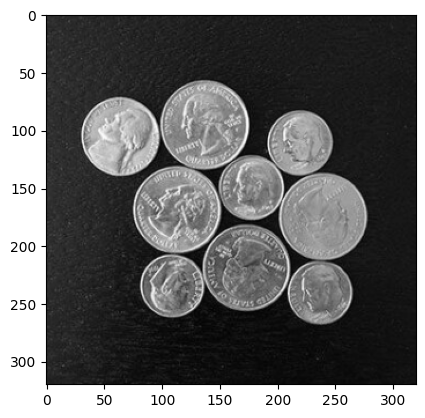

In [3]:
# tensor teansform and convert to grayscale
transform1 = transforms.ToTensor()
transform2 = transforms.Resize((320,320))
rgb_image = transform2(transform1(raw))

gs_img = rgb_image[0] * 0.299 + rgb_image[1] * 0.587 + rgb_image[2] * 0.114
plt.imshow(gs_img, cmap="grey", vmin=0, vmax=1)

## Bilateral Filter

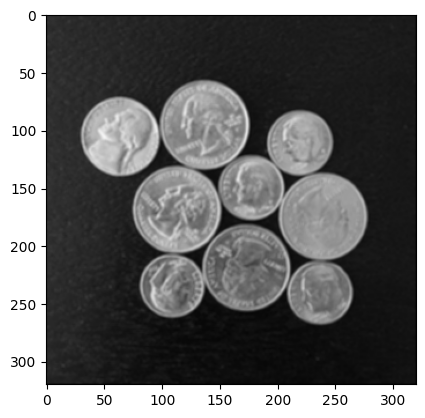

In [4]:

def bilateral_filter(input_image, kernel_size = 3, sigma_spatial = 2, sigma_range = 2):
    # index_prep = useful variable for calculations in order to work with kernel sizes and paddings
    index_prep = kernel_size // 2


    # create padded image
    padded_image = torch.zeros((input_image.shape[0] + kernel_size - 1, input_image.shape[1] + kernel_size - 1))
    # place padded image inside
    padded_image[index_prep:index_prep + input_image.shape[0], index_prep:index_prep + input_image.shape[1]] = input_image


    # create output bilinear image
    bilateral_filtered_image = torch.zeros(input_image.shape)

    # create spatial gaussian
    # create kernel
    kernel = torch.zeros(kernel_size, kernel_size, 2)
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i,j] = torch.tensor([ 0 + j - index_prep  , 0 + i - index_prep ])

    # gaussian function on range
    spatial_gaussian =  torch.exp( - ( kernel[:,:,0] ** 2 + kernel[:,:,1] ** 2) / (2 * sigma_spatial **2)) / (2 * torch.pi * sigma_spatial **2)

    # normalise
    spatial_gaussian = spatial_gaussian / spatial_gaussian.sum()


    for i in range(0, input_image.shape[0]):
        for j in range(0, input_image.shape[1]):

            # extract image
            extracted = padded_image[i:i+kernel_size, j:j+kernel_size]

            pixel_intensity = input_image[i,j]
            # calculate gausian 
            range_gaussian = torch.exp( - ( (extracted - pixel_intensity) ** 2) / (2 * sigma_range **2))  / (2 * torch.pi * sigma_range **2)
                                
            Wp = torch.sum(range_gaussian * spatial_gaussian)
            bilateral_filtering = torch.sum(range_gaussian * spatial_gaussian * extracted) / Wp
            bilateral_filtered_image[i,j] = bilateral_filtering
    
    return bilateral_filtered_image
        

smoothed_image = bilateral_filter(gs_img)
plt.imshow(smoothed_image, cmap='grey', vmin=0, vmax=1)

## Distance Transformation

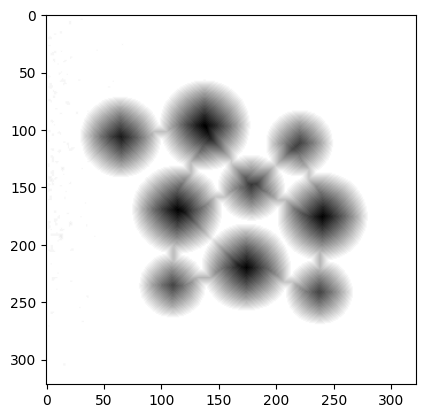

In [5]:
def distance_transformation(input_image, threshold):
    
    # threshold filtering
    input_image = torch.where(input_image > threshold, 1e6, 0)
    
    # create padded image
    padded_image = torch.full((input_image.shape[0] + 2 , input_image.shape[1] + 2), 0)

    # place padded image inside
    padded_image[1:-1, 1:-1] = input_image


    # forward pass (ignoring the padded pixels)
    for i in range(1, padded_image.shape[0] - 1):
        for j in range(1, padded_image.shape[1] - 1):
            padded_image[i,j] = torch.min(torch.tensor(([padded_image[i,j],
                                                                            padded_image[i - 1, j - 1] + math.sqrt(2), 
                                                                            padded_image[i - 1, j] + 1, 
                                                                            padded_image[i, j - 1] + 1, 
                                                                            padded_image[i - 1, j + 1] + math.sqrt(2)])))
    
    # backword pass (ignoring the padded pixels)
    for i in reversed(range(1, padded_image.shape[0] - 1)):
        for j in reversed(range(1, padded_image.shape[1] - 1)):
            padded_image[i,j] = torch.min(torch.tensor(([padded_image[i,j],
                                                        padded_image[i + 1, j - 1] + math.sqrt(2), 
                                                        padded_image[i + 1, j] + 1, 
                                                        padded_image[i, j + 1] + 1, 
                                                        padded_image[i + 1, j + 1] + math.sqrt(2)])))



    return padded_image

# calculate 2 pass Euclidean distance transformation 
distance_image = distance_transformation(smoothed_image, threshold=0.2)
# reverse, because we we have black background
distance_image = -distance_image
plt.imshow(distance_image, cmap='grey')

## Morphological Reconstruction

## Marked Watershed